# CoreMorph


In the basic algorithm, the graph fragments that make up the grammar are defined by a rootnode, a radius and a thickness. 
A fragment is called a $CIP_{radius}^{thickness}(root)$. The core is made up of all the nodes in a certain radius around the root. Interface part is 
the subgraph induced by every node in distance radius+thickness arround the root minus nodes in the core.


Here, we generate a graph minor (by contracting edges) for any given input graph. We extract the CIP from the graph minor.  Due to the contraction 
one node in the minor may represent any number of nodes in the unaltered graph. 
once we have the core in the unaltered graph, we can consider all nodes in THICKNES distance to this core and obtain a new interface. 

Core and interface of the unaltered graph are saved in the grammar.
There is still unused information in the interface of the minor graph. In the congruency check that will tell is if two CIPs are exchangeable, we not only check the unaltered graph interface but also the minor graphs interface. We hope that this will increase the score of the resulting applications of productions.

#### initialise nb

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

DEBUG=True
NJOBS=4
if DEBUG: NJOBS=1

from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1+DEBUG)

from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [2]:
# data source, see introduction for info.
from eden.io.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname='../toolsdata/bursi.pos.gspan', size=100):
    return  list(islice(gspan_to_eden(dataset_fname),size))
import warnings
warnings.filterwarnings('ignore')

# Meet the GraphTransformer (and the decomposer)

A graph transformer in general is used in two stages of the sampling process.
First on an incoming graph to make it graphlearnable. Then, after a graph was changed, it might get 
retransformed.
An example of this might be an RNA molecule that one wishes to refold after changing parts of the secondary structure graph.

The decomposer is the interface between graphs and graphlearn.
It is conducting substitutions of CIPs and extract CIPs from the graph.


As long as the decomposer is delivering acceptable data, the sampler will not care what the graph looks like.
It might not exist at all or have this second minorgraph version working in the background.


### Data Defined Transformation
In this first example, the graphminor generation is learned.
We do this by using the (one class) estimator to annotate the nodes in the graph, then the graph is contracted
on nodes with similar scores.
The subgraphs obtained in this way are then clustered and the clustername is used for the names of the parts.


# User Defined GraphTransformer

Here we see another example of a way to generate a graph minor.

Since we are working on molecules, cyclic structures are of interest.
Therefore it makes sense to introduce an abstraction based on these cycles.

In this case the graph minor generation is not learned but boringly generated.


##### notice how each cycle is contracted to one node in the minor graph.

In [3]:
from graphlearn.utils import draw
import graphlearn.minor.molecule.transform_cycle as mole
import graphlearn.minor.decompose as decompose
from graphlearn.graphlearn import Sampler as GLS
from eden.graph import Vectorizer

'''
decomposer = decompose.MinorDecomposer(include_base=False, base_thickness_list=[2])

#the preprocessor makes the abstraction, wrapper provides convenient format for drawing
preproc=mole.GraphTransformerCircles()
# get a graph and prepare it
graphs=get_graphs()
g=graphs.next()
graph_wrapper=decomposer.make_new_decomposer(preproc.wrap(g))
graph=graph_wrapper.pre_vectorizer_graph(nested=True)

# draw 
draw.graphlearn(graph,size=10, abstract_color='red', contract=True,ignore_for_layout='nesting')
'''

"\ndecomposer = decompose.MinorDecomposer(include_base=False, base_thickness_list=[2])\n\n#the preprocessor makes the abstraction, wrapper provides convenient format for drawing\npreproc=mole.GraphTransformerCircles()\n# get a graph and prepare it\ngraphs=get_graphs()\ng=graphs.next()\ngraph_wrapper=decomposer.make_new_decomposer(preproc.wrap(g))\ngraph=graph_wrapper.pre_vectorizer_graph(nested=True)\n\n# draw \ndraw.graphlearn(graph,size=10, abstract_color='red', contract=True,ignore_for_layout='nesting')\n"

# Generating a Sampler that uses GraphMinors

There are no modifications made to the sampler.
Just new decomposer and graphtransformer parameters are given.

In [4]:
from graphlearn.graphlearn import Sampler as graphlearn_sampler
from graphlearn.learnedlayer import transform
graphs = get_graphs(size=200)
import graphlearn.minor.decompose as decompose

sampler=graphlearn_sampler(
            decomposer=decompose.MinorDecomposer(),
            graphtransformer=transform.GraphMinorTransformer(group_score_threshold=0.4,num_classes=1,debug=False),
            n_samples=5,
     
            batch_size=1,
            n_steps=50,
            n_jobs=1,
            quick_skip_orig_cip=False,
            core_choice_byfrequency=True,
            burnin=0,
            improving_threshold_fraction=0.5,
            select_cip_max_tries=100,
            keep_duplicates=True,
            monitor=True,
            include_seed=True)

sampler.fit(graphs)
print 'done'

accept_min_similarity: 0.0
accept_static_penalty: 0.0
batch_size: 1
    burnin: 0
core_choice_bytrial: False
core_choice_bytrial_multiplier: 1.0
decomposer: no graphs in decomposer
estimatorobject: <graphlearn.estimate.OneClassEstimator instance at 0x7f1b0d245e60>
feasibility_checker: <graphlearn.feasibility.FeasibilityChecker instance at 0x7f1b0d245ea8>
graph_transformer: <graphlearn.learnedlayer.transform.GraphMinorTransformer object at 0x7f1b0b266510>
improving_linear_start_absolute: 0
improving_linear_start_fraction: 0
improving_penalty_per_step: 0.04
improving_threshold_absolute: 25
improving_threshold_fraction: 0.5
include_seed: True
keep_duplicates: True
      lsgg: <graphlearn.localsubstitutablegraphgrammar.LocalSubstitutableGraphGrammar object at 0x7f1b0d25f1d0>
maxbacktrack: 0
   monitor: True
  monitors: []
    n_jobs: 1
 n_samples: 5
   n_steps: 50
orig_cip_max_positives: 1
orig_cip_min_positives: 0
orig_cip_score_tricks: False
probabilistic_core_choice: True
proposal_proba

# Inspect the induced grammar

The first graph in each line shows the minor graph of the first CIP.
note that the minor-interfacegraph is the same for all CIPs, while the minor-core might be different.

interface id: 353772 [27 options]


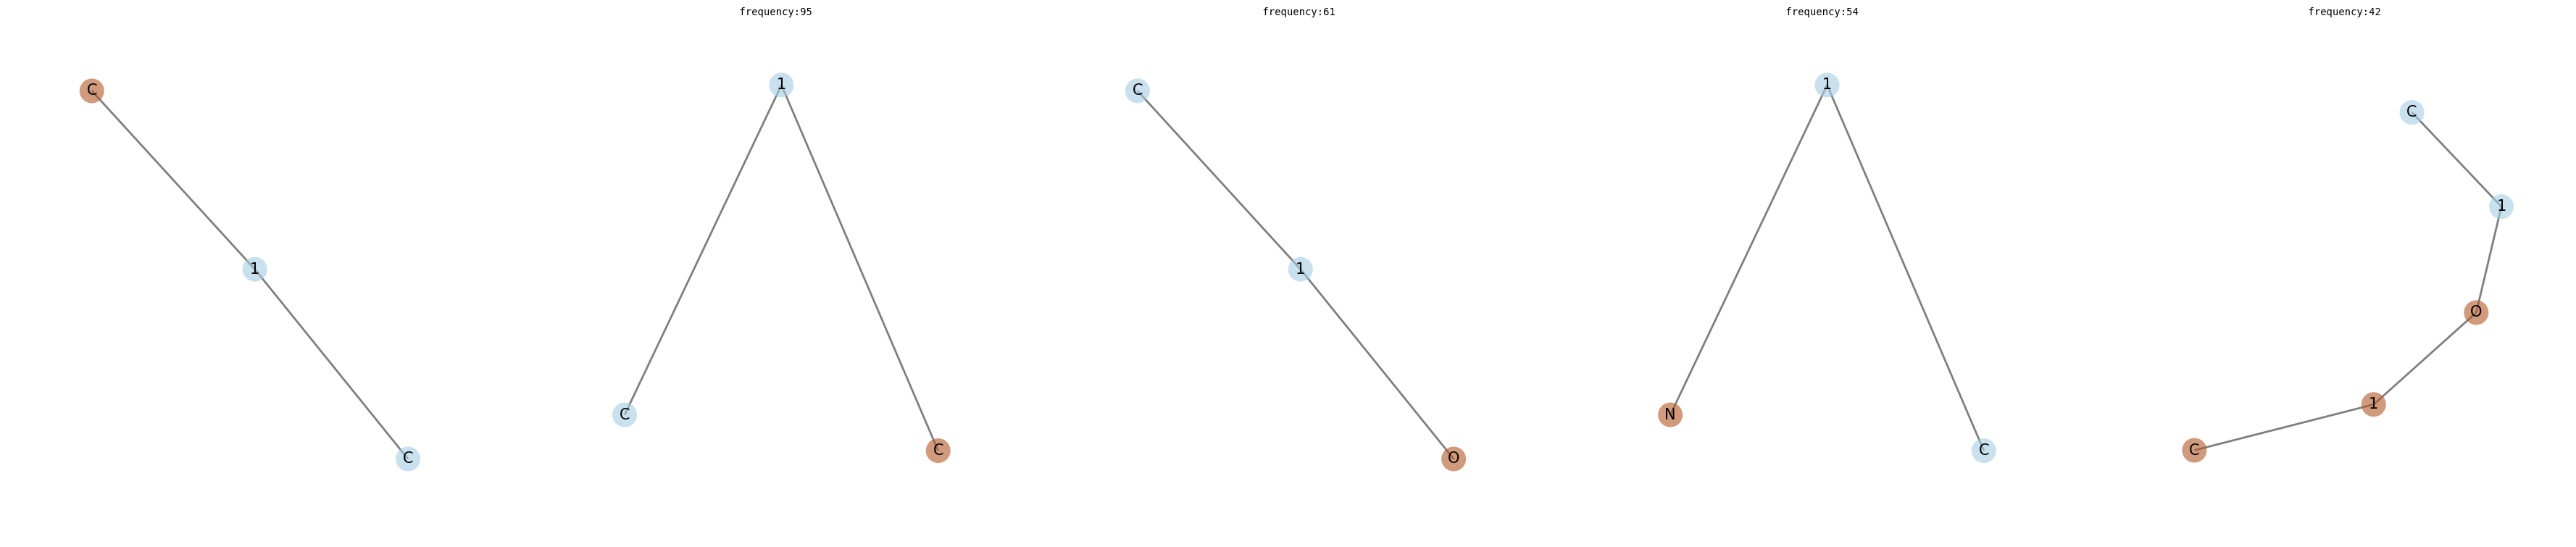

interface id: 401440 [26 options]


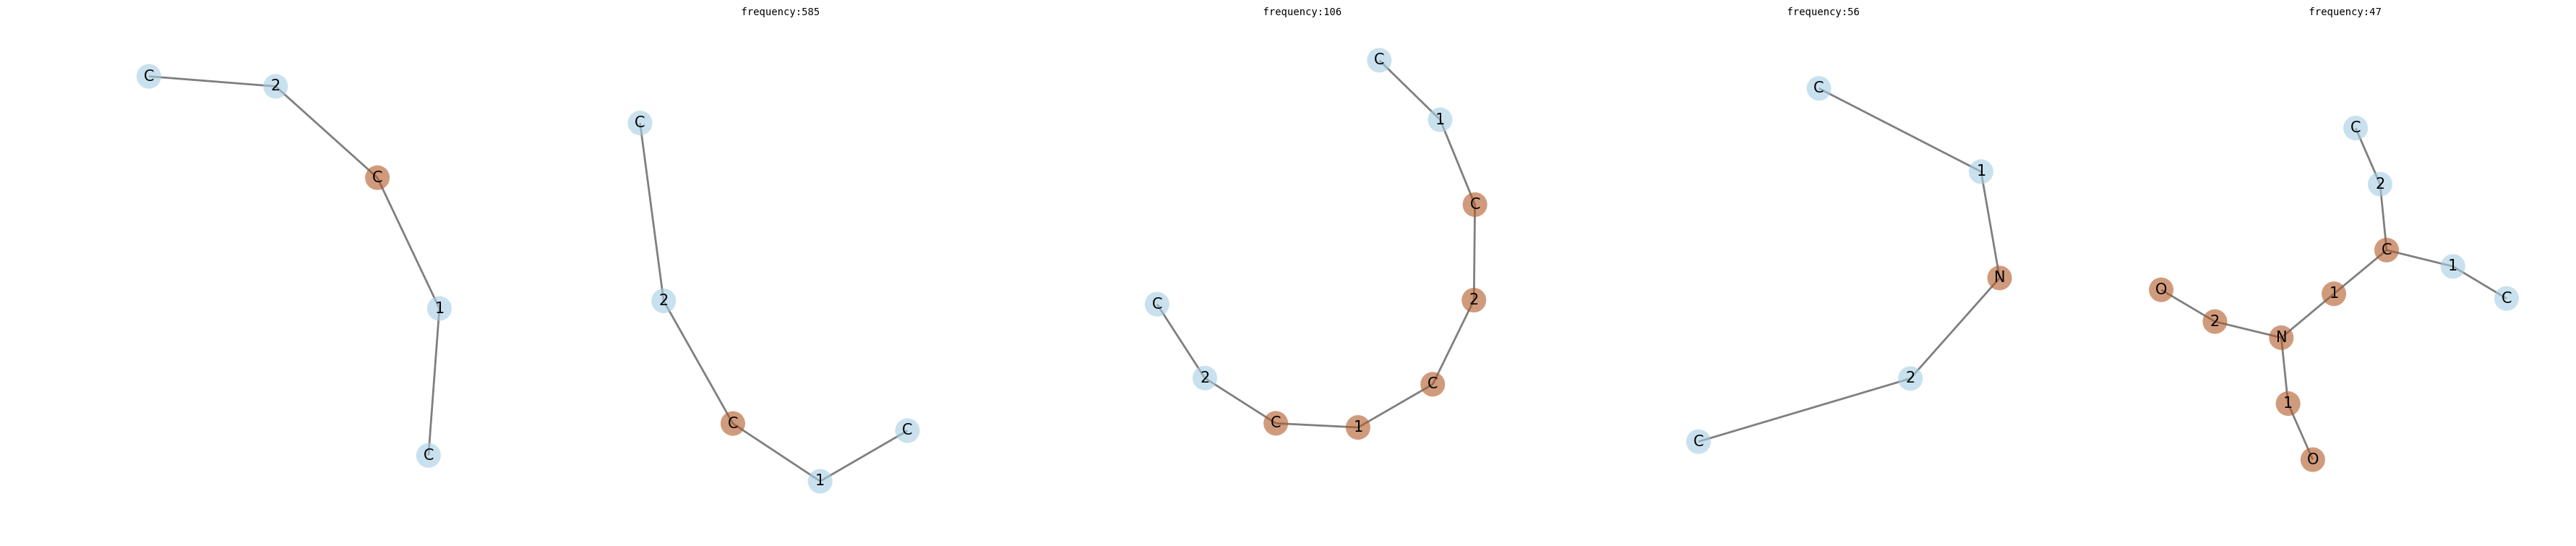

interface id: 53612 [24 options]


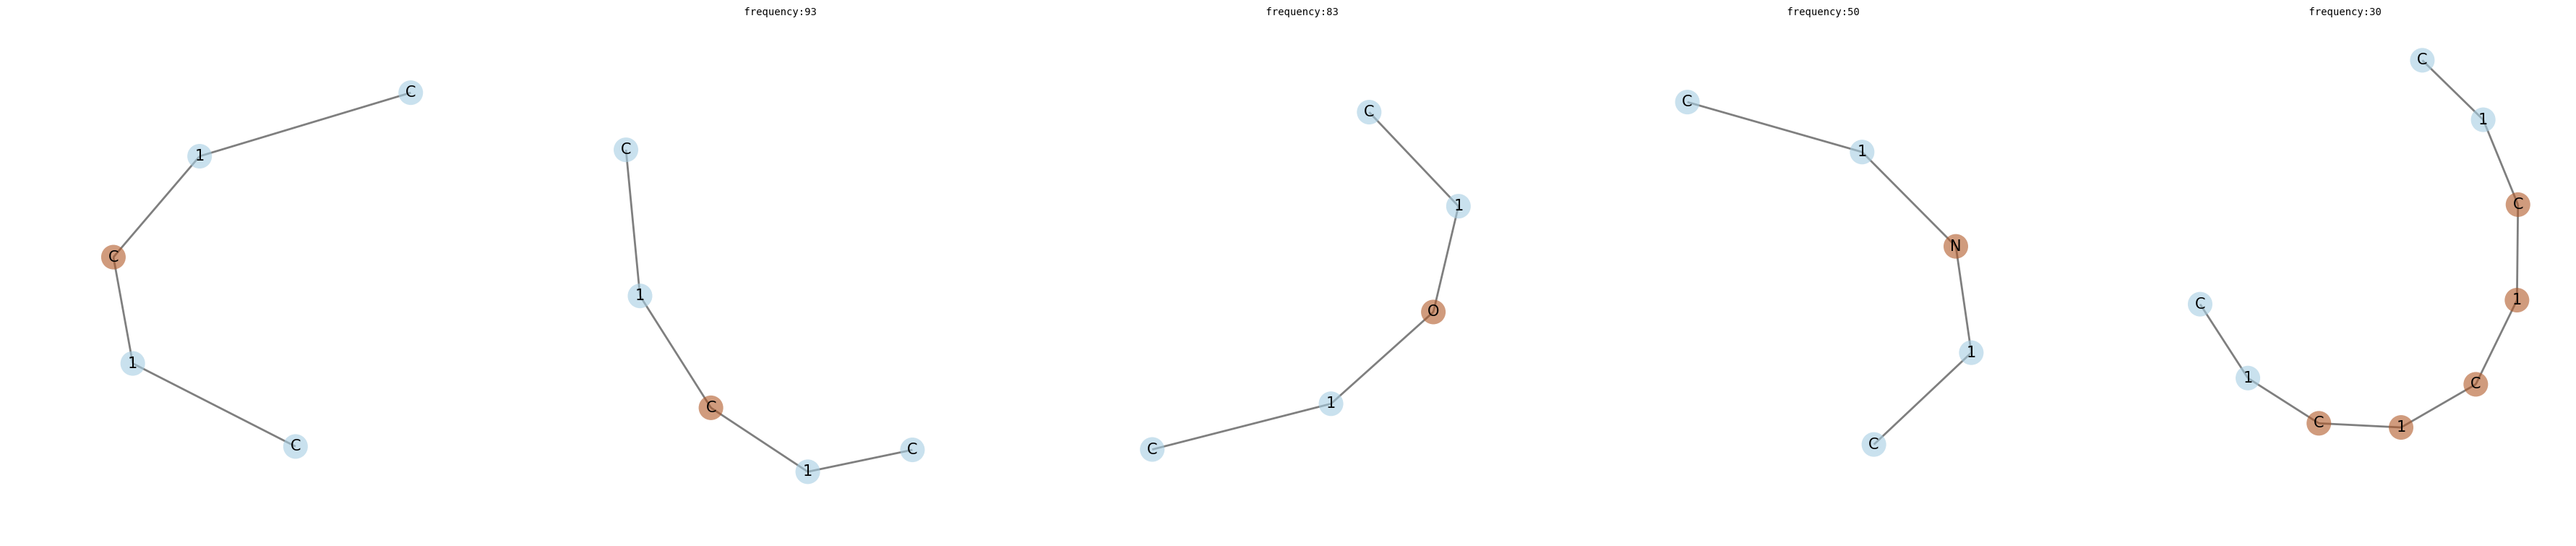

In [5]:
if True:
    draw.draw_grammar(sampler.lsgg.productions,n_productions=3,n_graphs_per_production=5,
                         n_graphs_per_line=5, size=9, contract=False,
                         colormap='Paired', invert_colormap=False,
                         vertex_alpha=0.6, edge_alpha=0.5,  abstract_interface=True)

# sample molecules

Sampling works exactly the same way as before.

In [6]:
import itertools

#parameters
graphs = get_graphs()
id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=50


# sampling with many arguments.
graphs = sampler.transform(graphs)

 

preprocessing grammar
_propose_graph: iteration 0 ; core 0 of 1 ; original_cips tried  0 ; size 45
_propose_graph: iteration 1 ; core 0 of 6 ; original_cips tried  0 ; size 45
_propose_graph: iteration 2 ; core 0 of 9 ; original_cips tried  0 ; size 45
_propose_graph: iteration 3 ; core 0 of 17 ; original_cips tried  0 ; size 49
_propose_graph: iteration 4 ; core 0 of 25 ; original_cips tried  0 ; size 45
_propose_graph: iteration 5 ; core 0 of 23 ; original_cips tried  0 ; size 41
_propose_graph: iteration 6 ; core 0 of 17 ; original_cips tried  0 ; size 43
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0 ; size 43
_propose_graph: iteration 8 ; core 0 of 10 ; original_cips tried  0 ; size 43
_propose_graph: iteration 9 ; core 0 of 1 ; original_cips tried  0 ; size 43
_propose_graph: iteration 10 ; core 0 of 17 ; original_cips tried  0 ; size 43
_propose_graph: iteration 11 ; core 0 of 5 ; original_cips tried  0 ; size 43
_propose_graph: iteration 12 ; core 0 of 1 ; o

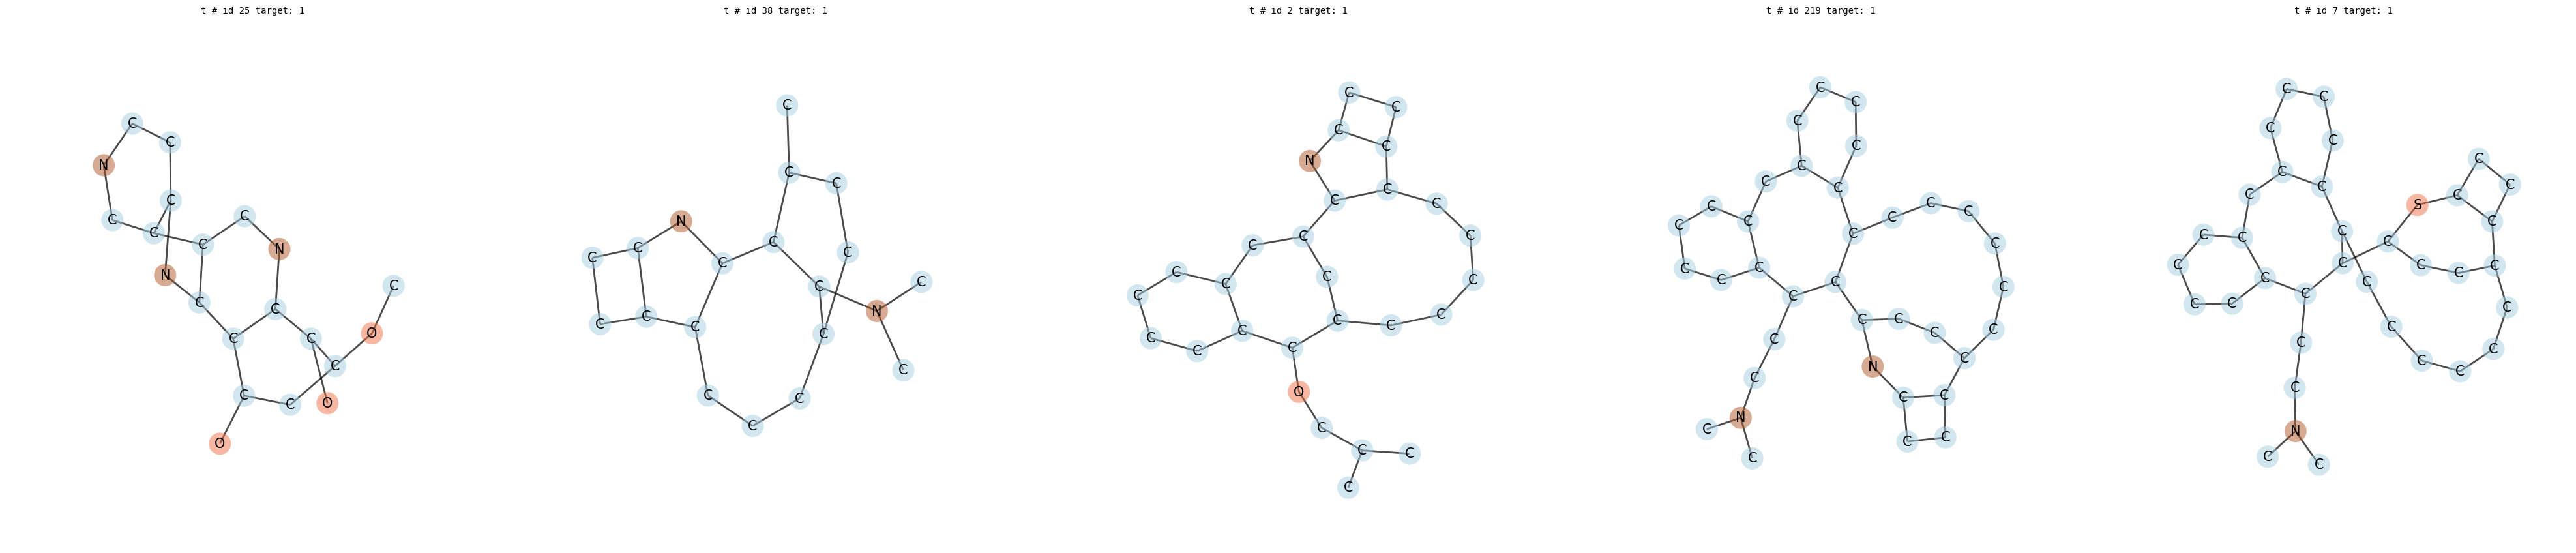

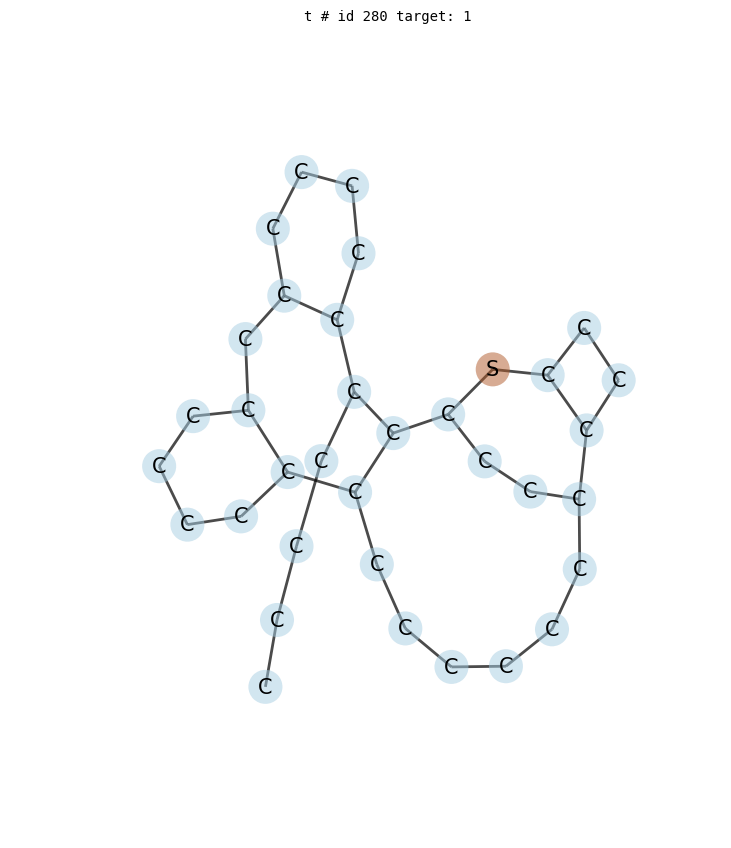

_propose_graph: iteration 0 ; core 0 of 17 ; original_cips tried  0 ; size 29
_propose_graph: iteration 1 ; core 0 of 1 ; original_cips tried  0 ; size 33
_propose_graph: iteration 2 ; core 0 of 25 ; original_cips tried  0 ; size 33
_propose_graph: iteration 3 ; core 0 of 3 ; original_cips tried  0 ; size 33
_propose_graph: iteration 4 ; core 0 of 25 ; original_cips tried  0 ; size 33
_propose_graph: iteration 5 ; core 0 of 3 ; original_cips tried  0 ; size 33
_propose_graph: iteration 6 ; core 0 of 5 ; original_cips tried  0 ; size 39
_propose_graph: iteration 7 ; core 0 of 17 ; original_cips tried  0 ; size 39
_propose_graph: iteration 8 ; core 0 of 9 ; original_cips tried  0 ; size 39
_propose_graph: iteration 9 ; core 0 of 5 ; original_cips tried  0 ; size 39
_propose_graph: iteration 10 ; core 0 of 7 ; original_cips tried  0 ; size 39
_propose_graph: iteration 11 ; core 0 of 2 ; original_cips tried  0 ; size 37
_propose_graph: iteration 12 ; core 0 of 23 ; original_cips tried  0 ;

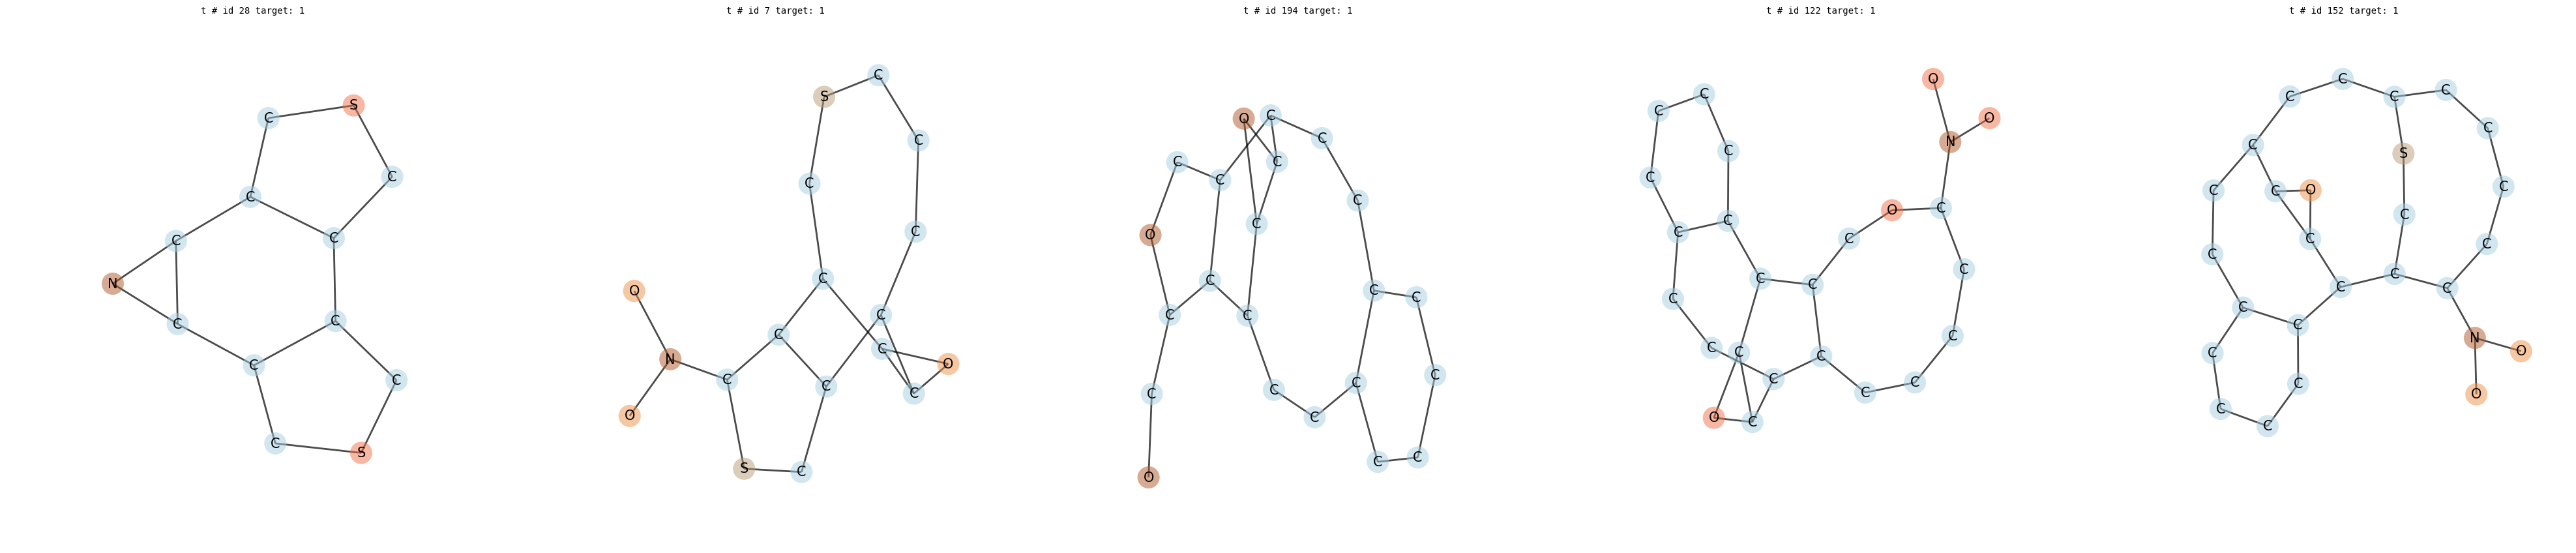

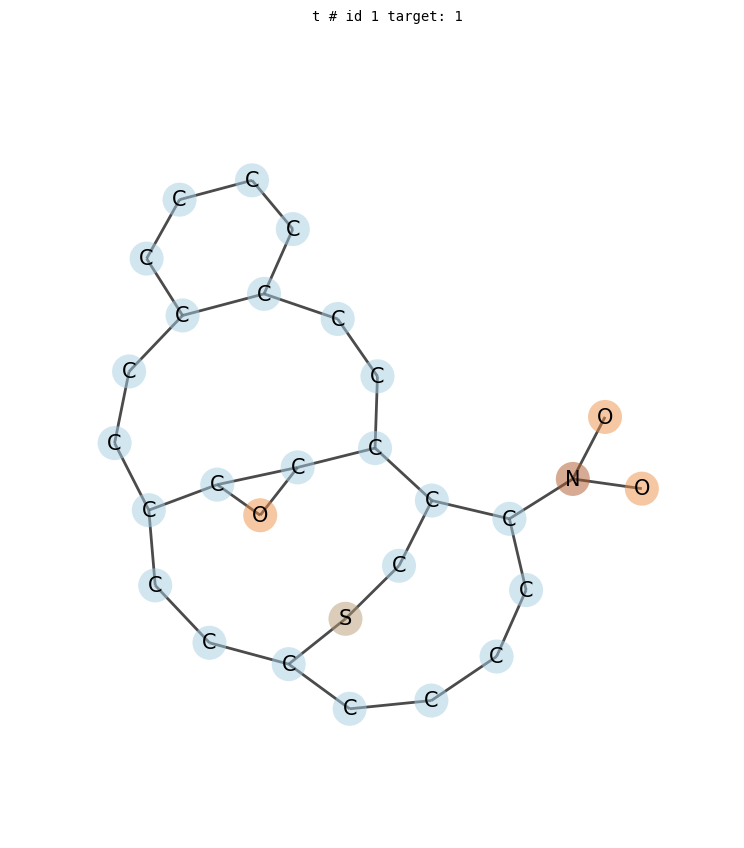

_propose_graph: iteration 0 ; core 0 of 2 ; original_cips tried  0 ; size 35
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0 ; size 35
_propose_graph: iteration 2 ; core 0 of 26 ; original_cips tried  0 ; size 37
_propose_graph: iteration 3 ; core 0 of 1 ; original_cips tried  0 ; size 39
_propose_graph: iteration 4 ; core 0 of 25 ; original_cips tried  0 ; size 33
_propose_graph: iteration 5 ; core 0 of 4 ; original_cips tried  0 ; size 33
_propose_graph: iteration 6 ; core 0 of 9 ; original_cips tried  0 ; size 29
_propose_graph: iteration 7 ; core 0 of 17 ; original_cips tried  0 ; size 25
_propose_graph: iteration 8 ; core 0 of 25 ; original_cips tried  0 ; size 27
_propose_graph: iteration 9 ; core 0 of 2 ; original_cips tried  0 ; size 27
_propose_graph: iteration 10 ; core 0 of 3 ; original_cips tried  0 ; size 27
_propose_graph: iteration 11 ; core 0 of 10 ; original_cips tried  0 ; size 27
_propose_graph: iteration 12 ; core 0 of 25 ; original_cips tried  0 

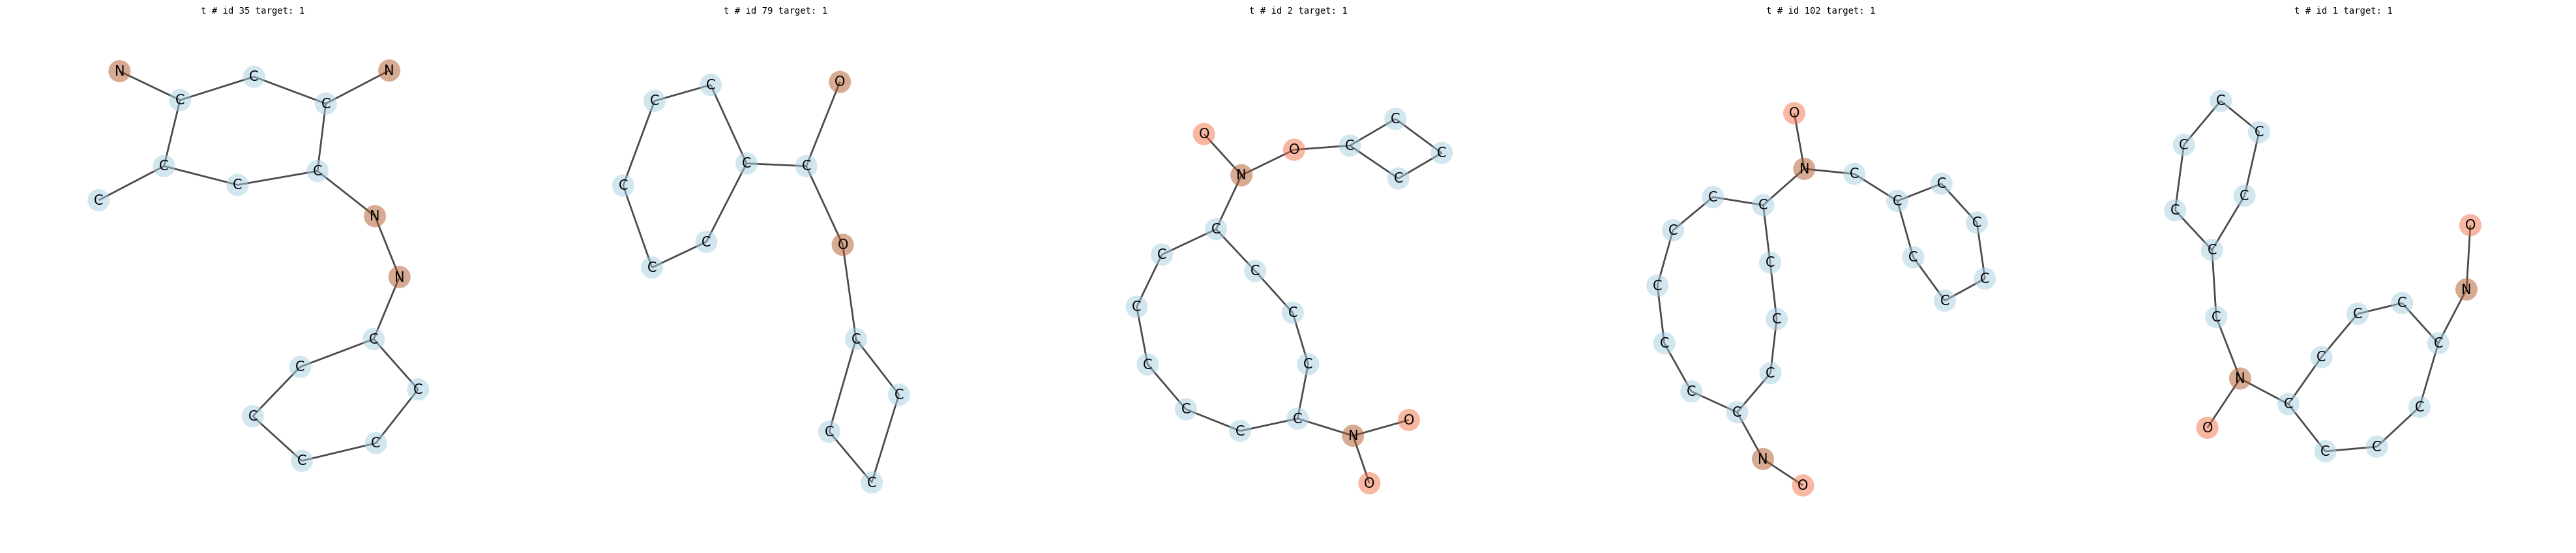

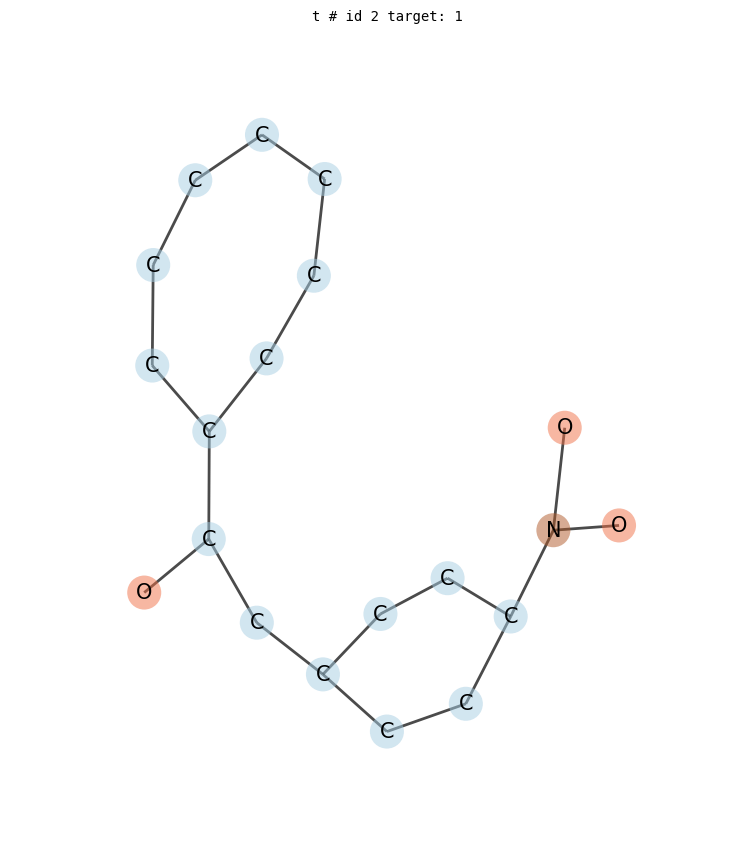

_propose_graph: iteration 0 ; core 0 of 25 ; original_cips tried  0 ; size 35
_propose_graph: iteration 1 ; core 0 of 26 ; original_cips tried  0 ; size 39
_propose_graph: iteration 2 ; core 0 of 14 ; original_cips tried  0 ; size 39
_propose_graph: iteration 3 ; core 0 of 6 ; original_cips tried  0 ; size 41
_propose_graph: iteration 4 ; core 0 of 9 ; original_cips tried  0 ; size 41
_propose_graph: iteration 5 ; core 0 of 25 ; original_cips tried  0 ; size 41
_propose_graph: iteration 6 ; core 0 of 25 ; original_cips tried  0 ; size 45
_propose_graph: iteration 7 ; core 0 of 7 ; original_cips tried  0 ; size 49
_propose_graph: iteration 8 ; core 0 of 17 ; original_cips tried  0 ; size 49
_propose_graph: iteration 9 ; core 0 of 14 ; original_cips tried  0 ; size 49
_propose_graph: iteration 10 ; core 0 of 17 ; original_cips tried  0 ; size 49
_propose_graph: iteration 11 ; core 0 of 17 ; original_cips tried  0 ; size 45
_propose_graph: iteration 12 ; core 0 of 10 ; original_cips tried

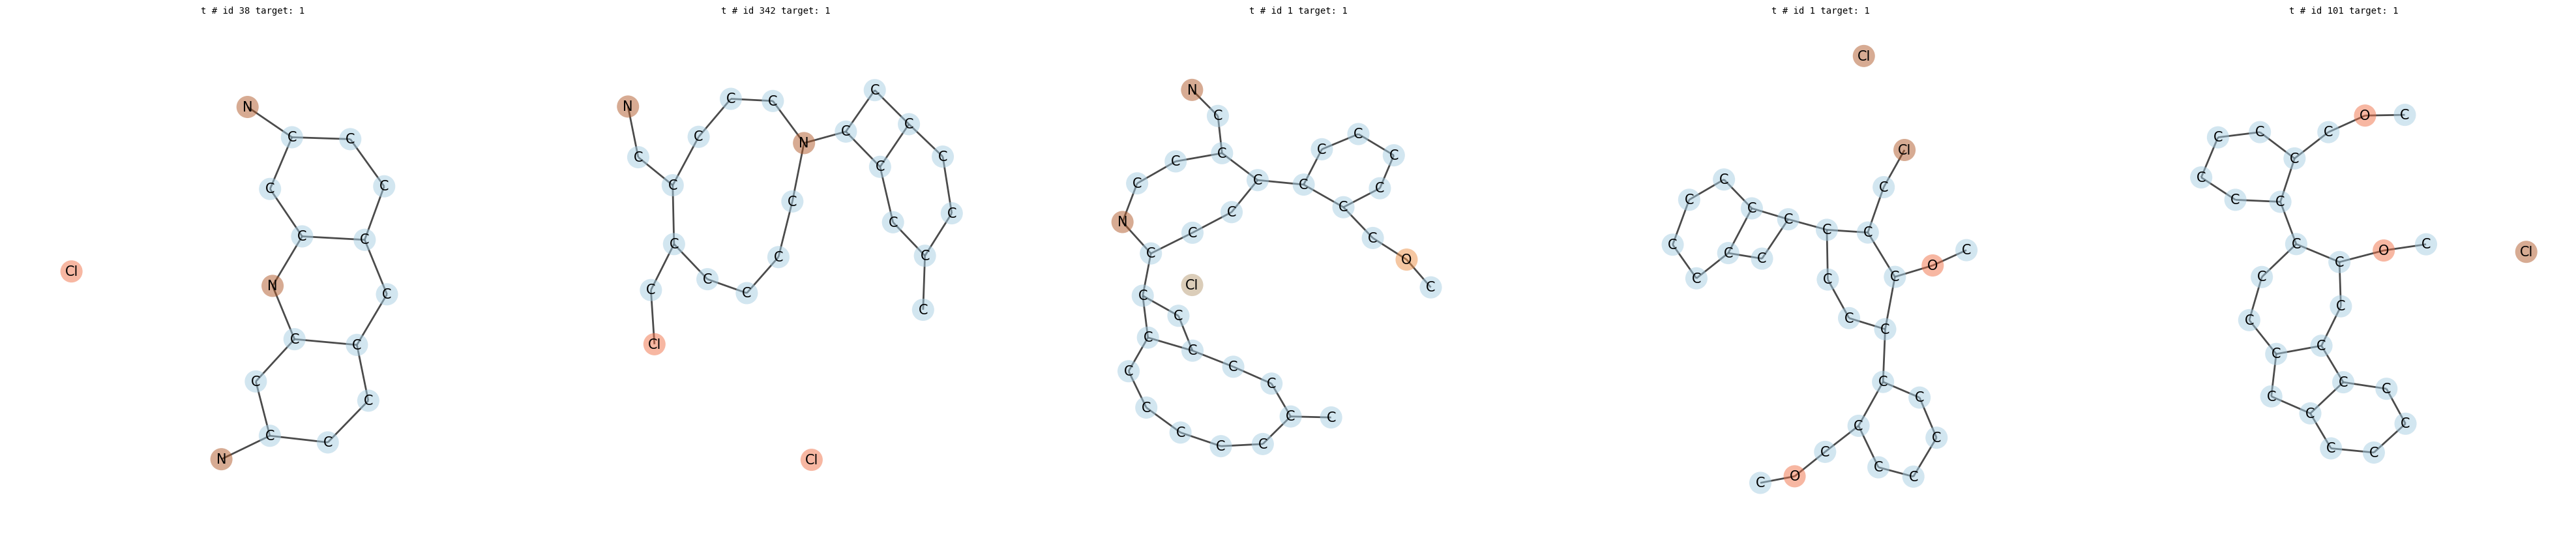

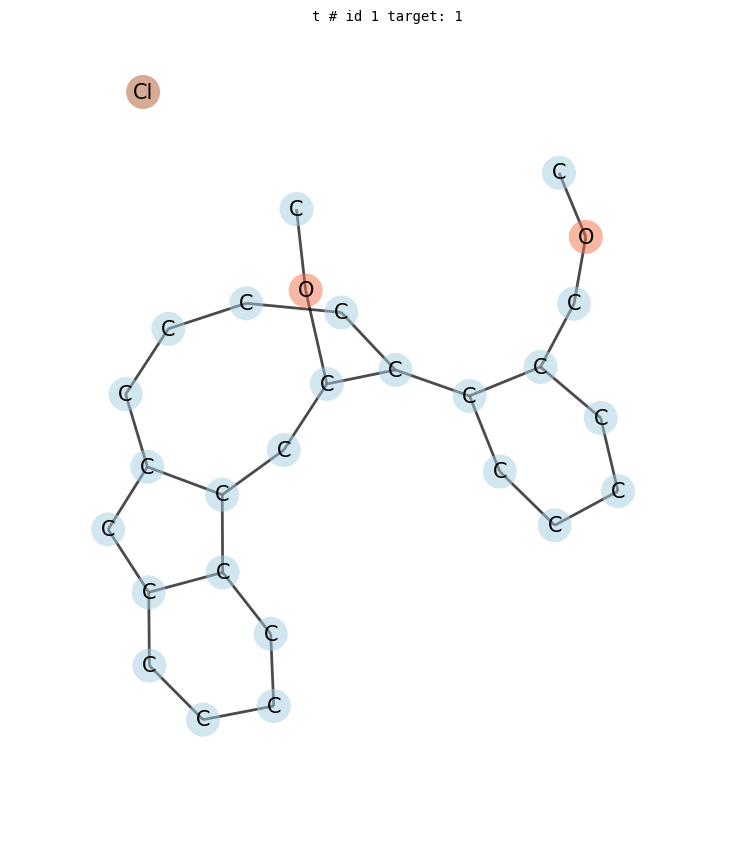

_propose_graph: iteration 0 ; core 0 of 17 ; original_cips tried  0 ; size 32
_propose_graph: iteration 1 ; core 0 of 15 ; original_cips tried  0 ; size 36
_propose_graph: iteration 2 ; core 0 of 17 ; original_cips tried  0 ; size 36
_propose_graph: iteration 3 ; core 0 of 23 ; original_cips tried  0 ; size 40
_propose_graph: iteration 4 ; core 0 of 2 ; original_cips tried  0 ; size 40
_propose_graph: iteration 5 ; core 0 of 15 ; original_cips tried  0 ; size 40
_propose_graph: iteration 6 ; core 0 of 6 ; original_cips tried  0 ; size 34
_propose_graph: iteration 7 ; core 0 of 7 ; original_cips tried  0 ; size 34
_propose_graph: iteration 8 ; core 0 of 2 ; original_cips tried  0 ; size 45
_propose_graph: iteration 9 ; core 0 of 3 ; original_cips tried  0 ; size 32
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 32
_propose_graph: iteration 11 ; core 0 of 23 ; original_cips tried  0 ; size 32
_propose_graph: iteration 12 ; core 0 of 26 ; original_cips tried  0

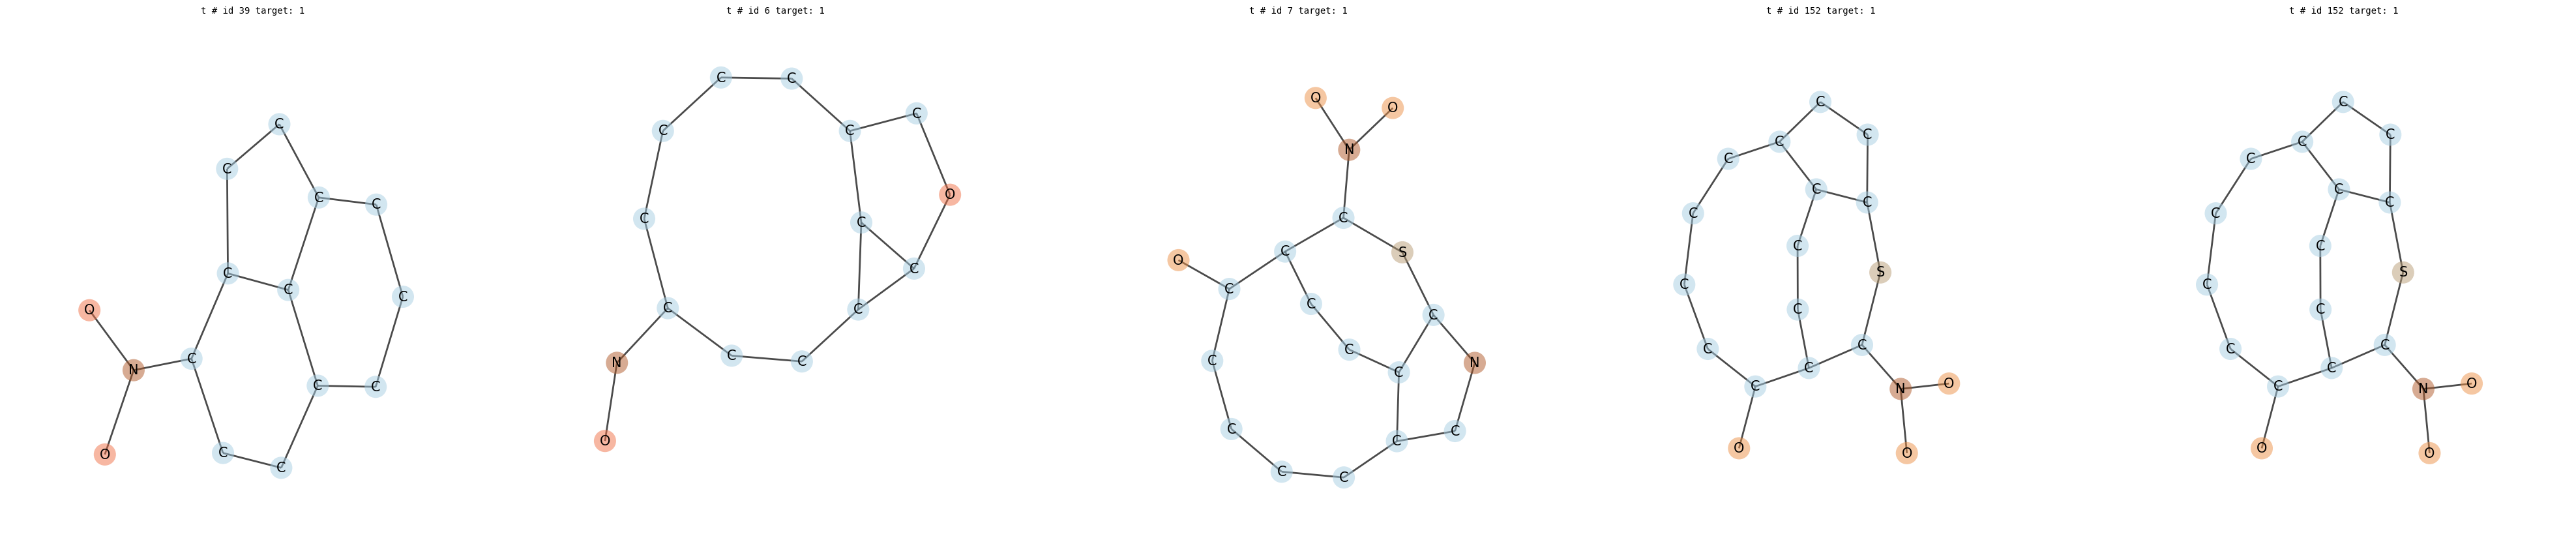

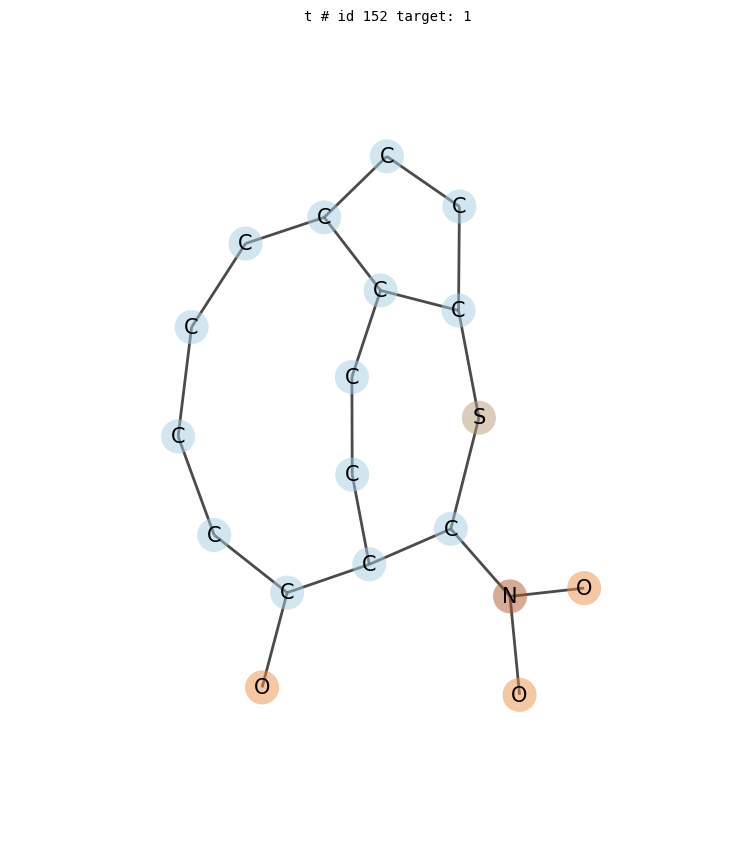

_propose_graph: iteration 0 ; core 0 of 6 ; original_cips tried  0 ; size 83
_propose_graph: iteration 1 ; core 0 of 25 ; original_cips tried  0 ; size 85
_propose_graph: iteration 2 ; core 0 of 1 ; original_cips tried  0 ; size 83
_propose_graph: iteration 3 ; core 0 of 23 ; original_cips tried  0 ; size 83
_propose_graph: iteration 4 ; core 0 of 9 ; original_cips tried  0 ; size 83
_propose_graph: iteration 5 ; core 0 of 2 ; original_cips tried  0 ; size 77
_propose_graph: iteration 6 ; core 0 of 17 ; original_cips tried  0 ; size 77
_propose_graph: iteration 7 ; core 0 of 2 ; original_cips tried  0 ; size 83
_propose_graph: iteration 8 ; core 0 of 3 ; original_cips tried  0 ; size 83
_propose_graph: iteration 9 ; core 0 of 17 ; original_cips tried  0 ; size 83
_propose_graph: iteration 10 ; core 0 of 1 ; original_cips tried  0 ; size 87
_propose_graph: iteration 11 ; core 0 of 2 ; original_cips tried  0 ; size 87
_propose_graph: iteration 12 ; core 0 of 1 ; original_cips tried  0 ; 

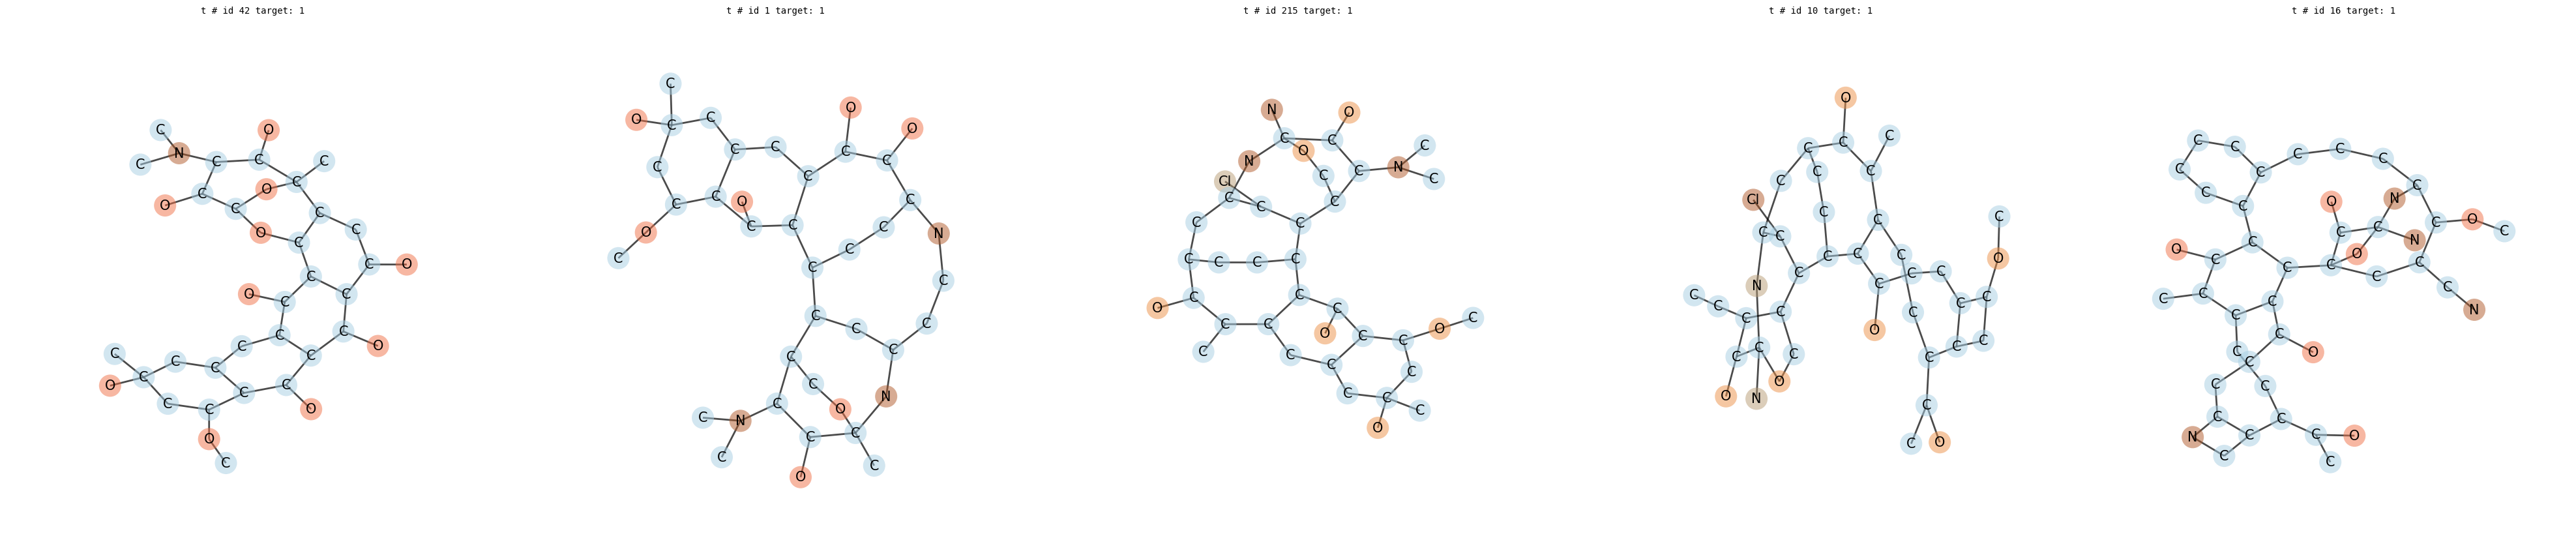

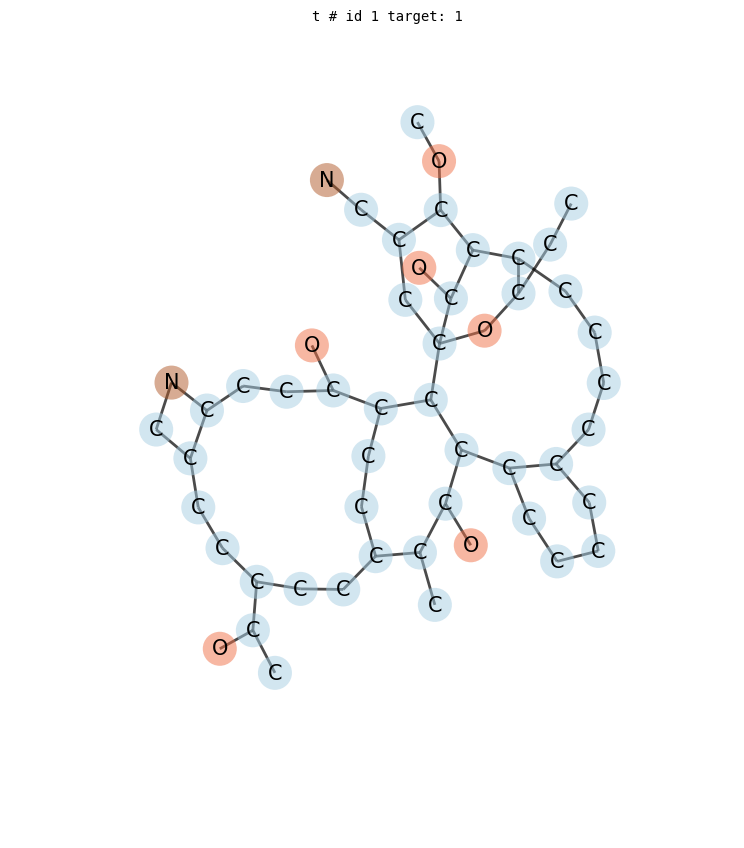

_propose_graph: iteration 0 ; core 0 of 9 ; original_cips tried  0 ; size 37
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0 ; size 33
_propose_graph: iteration 2 ; core 0 of 1 ; original_cips tried  0 ; size 33
_propose_graph: iteration 3 ; core 0 of 23 ; original_cips tried  0 ; size 39
_propose_graph: iteration 4 ; core 0 of 6 ; original_cips tried  0 ; size 39
_propose_graph: iteration 5 ; core 0 of 3 ; original_cips tried  0 ; size 26
_propose_graph: iteration 6 ; core 0 of 23 ; original_cips tried  0 ; size 30
_propose_graph: iteration 7 ; core 0 of 26 ; original_cips tried  0 ; size 41
_propose_graph: iteration 8 ; core 0 of 26 ; original_cips tried  0 ; size 41
_propose_graph: iteration 9 ; core 0 of 23 ; original_cips tried  0 ; size 41
_propose_graph: iteration 10 ; core 0 of 3 ; original_cips tried  0 ; size 41
_propose_graph: iteration 11 ; core 0 of 23 ; original_cips tried  0 ; size 41
_propose_graph: iteration 12 ; core 0 of 23 ; original_cips tried  0

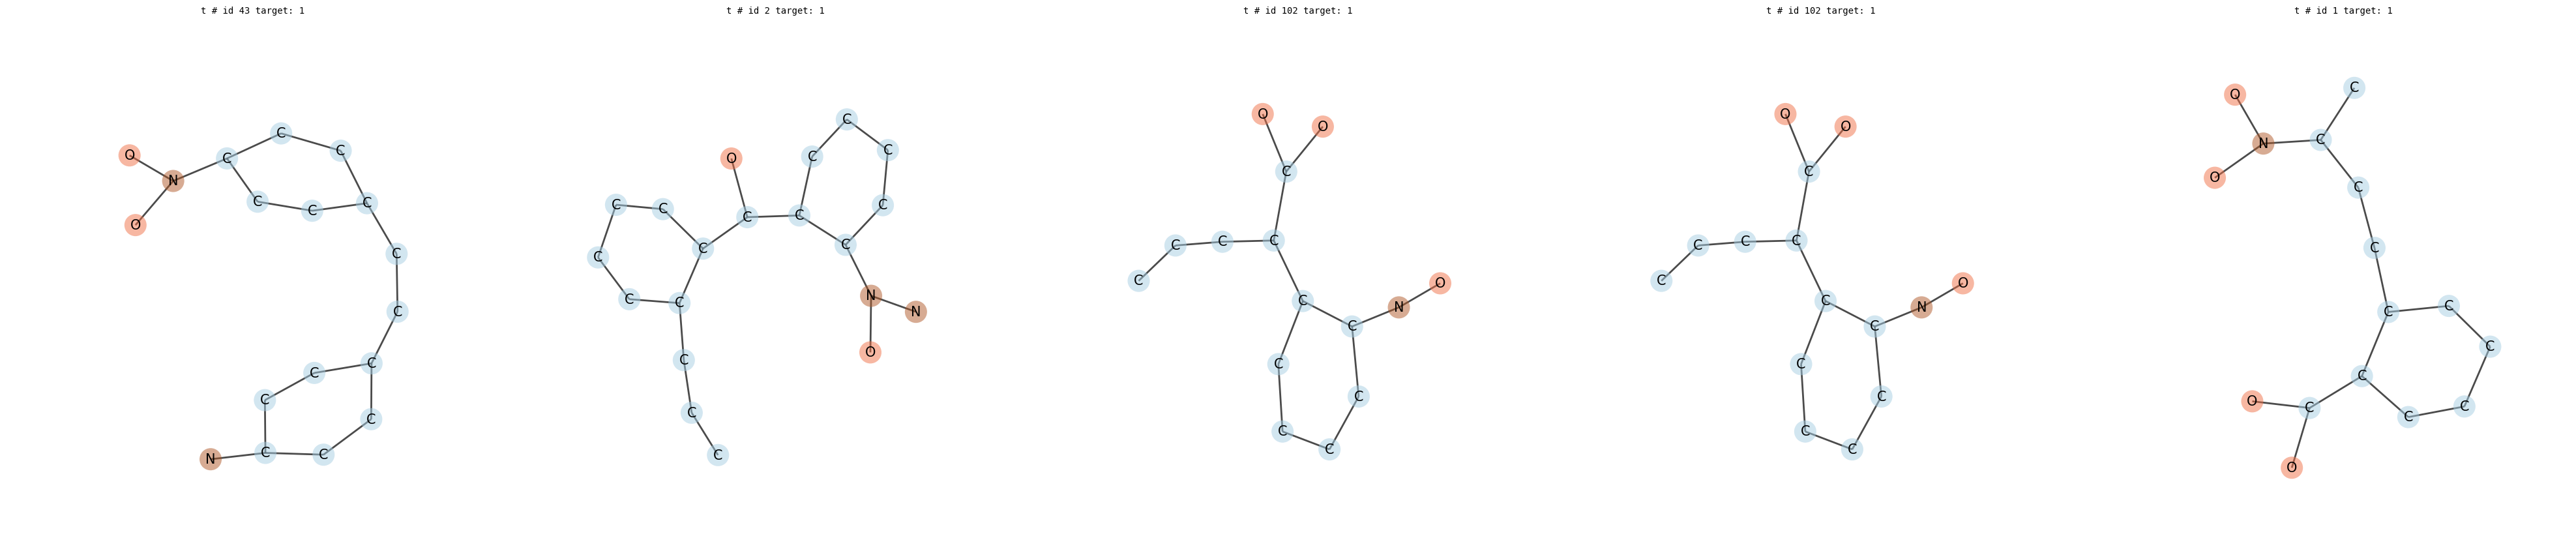

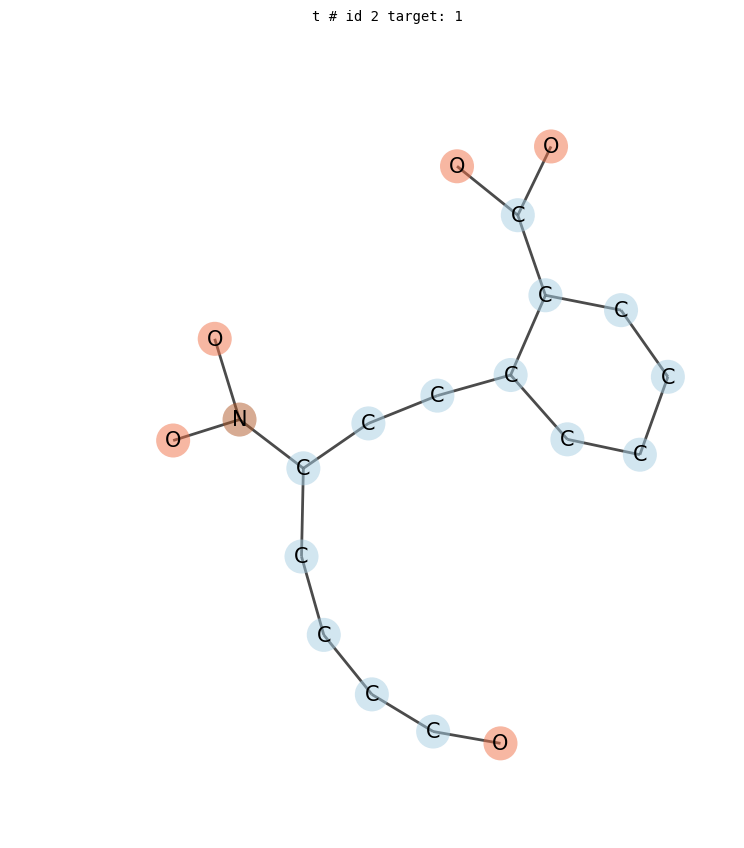

_propose_graph: iteration 0 ; core 0 of 4 ; original_cips tried  0 ; size 32
_propose_graph: iteration 1 ; core 0 of 2 ; original_cips tried  0 ; size 32
_propose_graph: iteration 2 ; core 0 of 11 ; original_cips tried  0 ; size 34
_propose_graph: iteration 3 ; core 0 of 2 ; original_cips tried  0 ; size 32
_propose_graph: iteration 4 ; core 0 of 1 ; original_cips tried  0 ; size 36
_propose_graph: iteration 5 ; core 0 of 1 ; original_cips tried  0 ; size 38
_propose_graph: iteration 6 ; core 0 of 9 ; original_cips tried  0 ; size 42
_propose_graph: iteration 7 ; core 0 of 3 ; original_cips tried  0 ; size 40
_propose_graph: iteration 8 ; core 0 of 3 ; original_cips tried  0 ; size 38
_propose_graph: iteration 9 ; core 0 of 3 ; original_cips tried  0 ; size 38
_propose_graph: iteration 10 ; core 0 of 2 ; original_cips tried  0 ; size 34
_propose_graph: iteration 11 ; core 0 of 26 ; original_cips tried  0 ; size 38
_propose_graph: iteration 12 ; core 0 of 1 ; original_cips tried  0 ; si

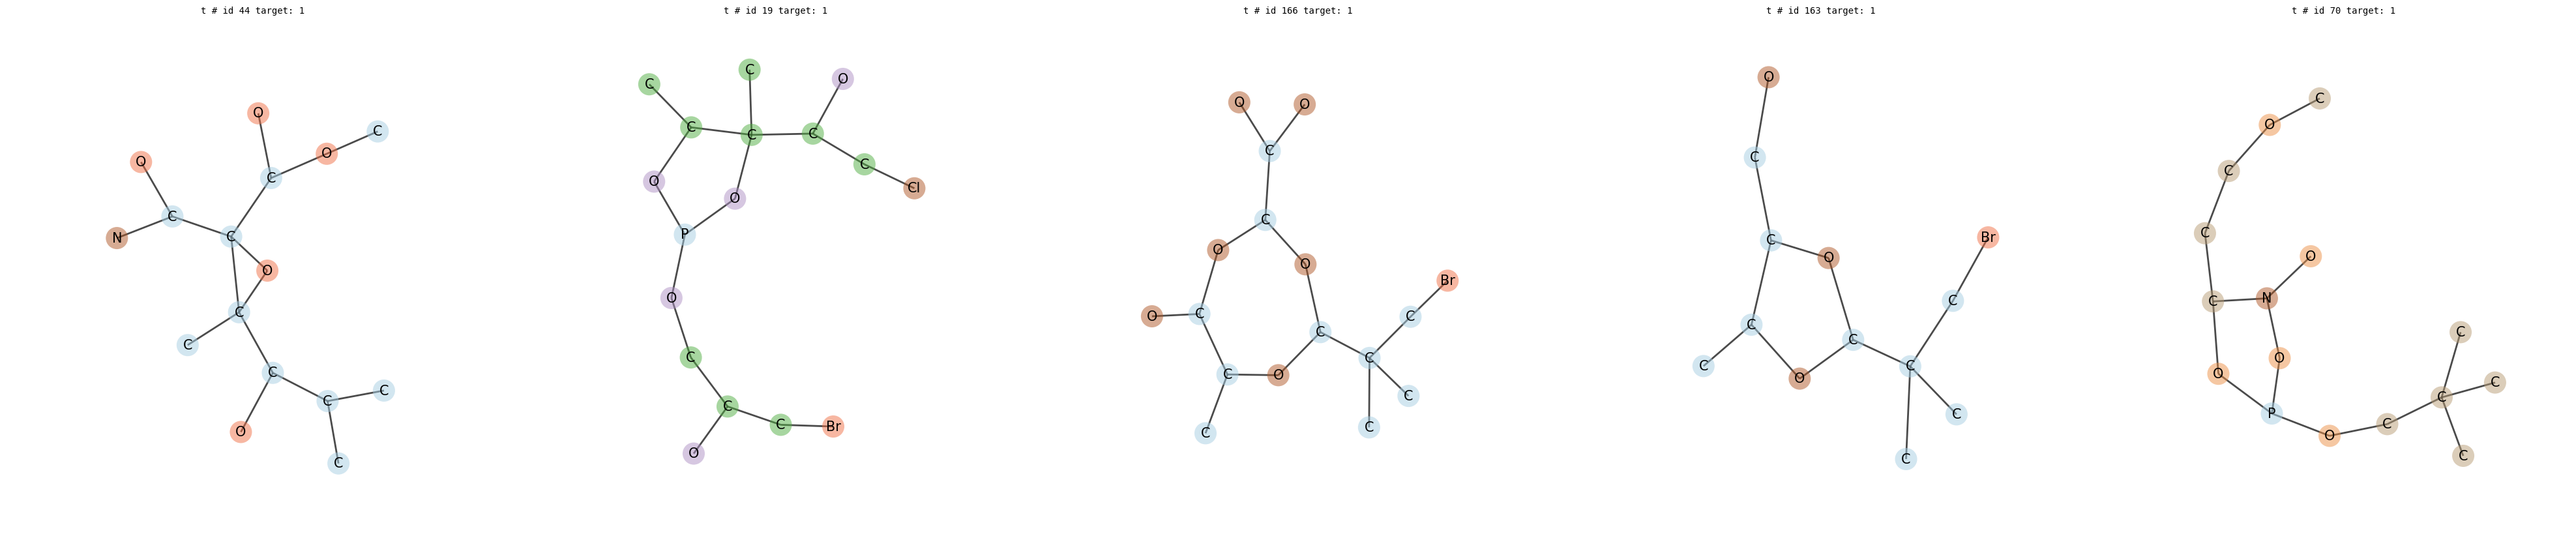

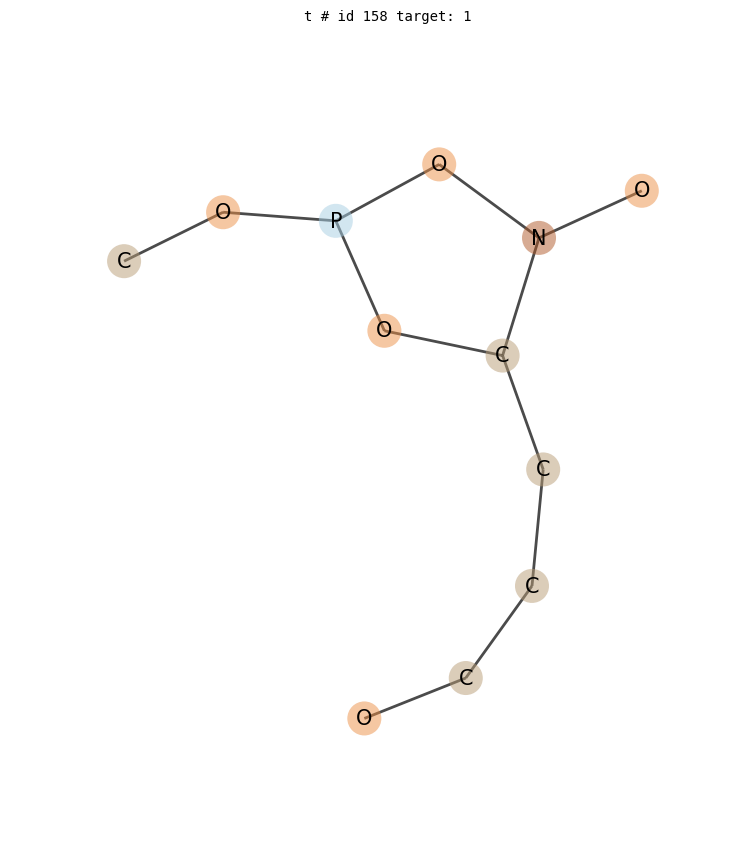

_propose_graph: iteration 0 ; core 0 of 23 ; original_cips tried  0 ; size 20
_propose_graph: iteration 1 ; core 0 of 26 ; original_cips tried  0 ; size 24
_propose_graph: iteration 2 ; core 0 of 7 ; original_cips tried  0 ; size 26
_propose_graph: iteration 3 ; core 0 of 23 ; original_cips tried  0 ; size 26
_propose_graph: iteration 4 ; core 0 of 4 ; original_cips tried  0 ; size 22
_propose_graph: iteration 5 ; core 0 of 4 ; original_cips tried  0 ; size 22
_propose_graph: iteration 6 ; core 0 of 7 ; original_cips tried  0 ; size 22
_propose_graph: iteration 7 ; core 0 of 23 ; original_cips tried  0 ; size 24
_propose_graph: iteration 8 ; core 0 of 3 ; original_cips tried  0 ; size 28
_propose_graph: iteration 9 ; core 0 of 7 ; original_cips tried  0 ; size 22
_propose_graph: iteration 10 ; core 0 of 26 ; original_cips tried  0 ; size 22
_propose_graph: iteration 11 ; core 0 of 11 ; original_cips tried  0 ; size 20
_propose_graph: iteration 12 ; core 0 of 26 ; original_cips tried  0

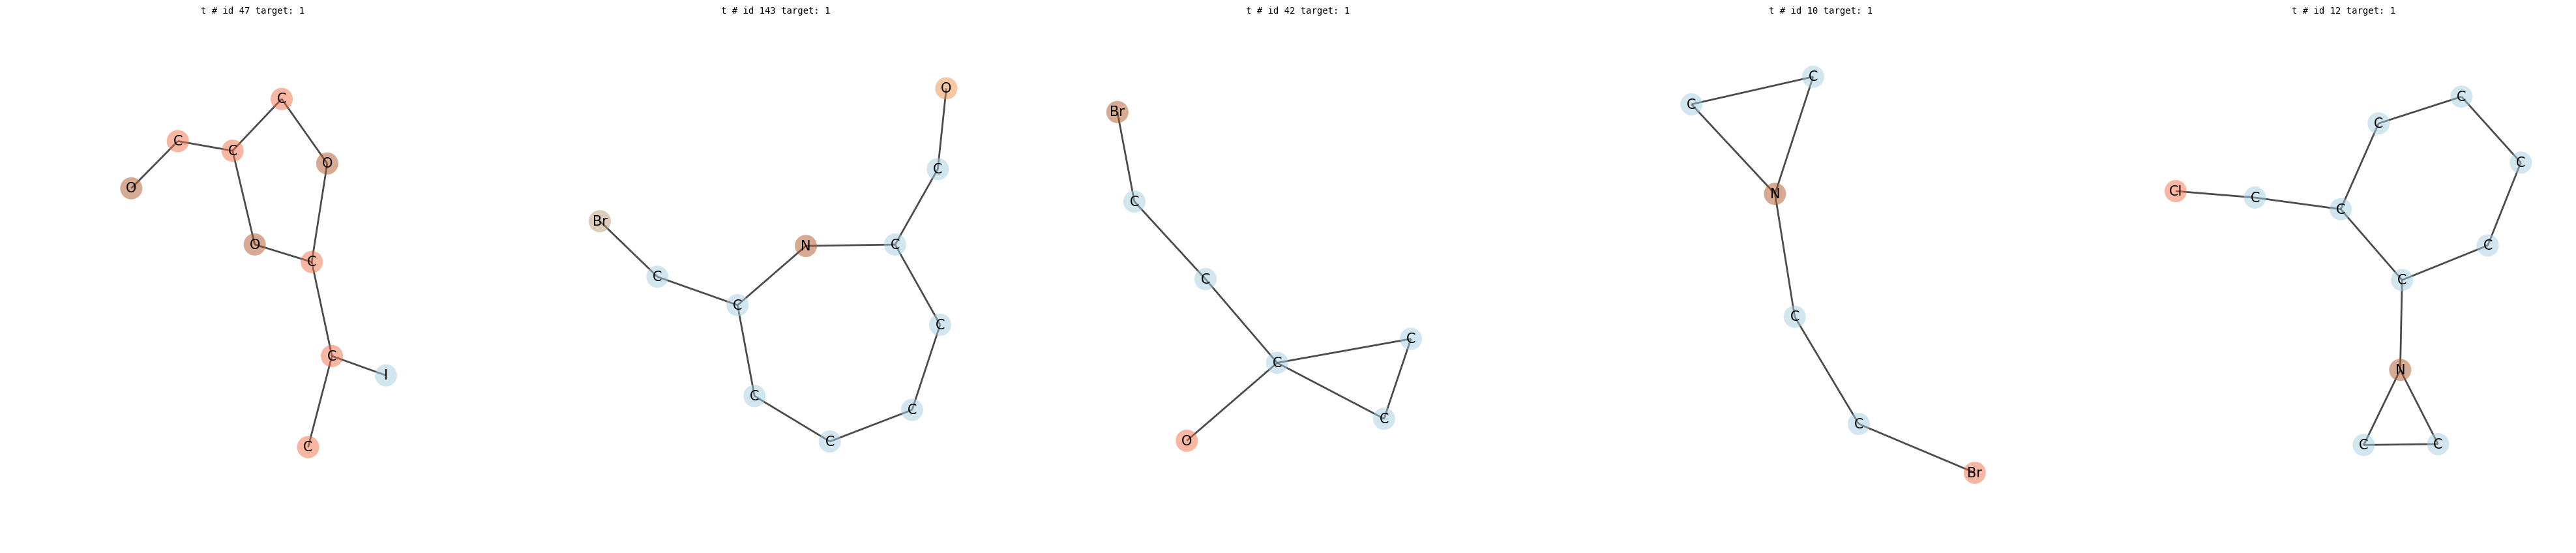

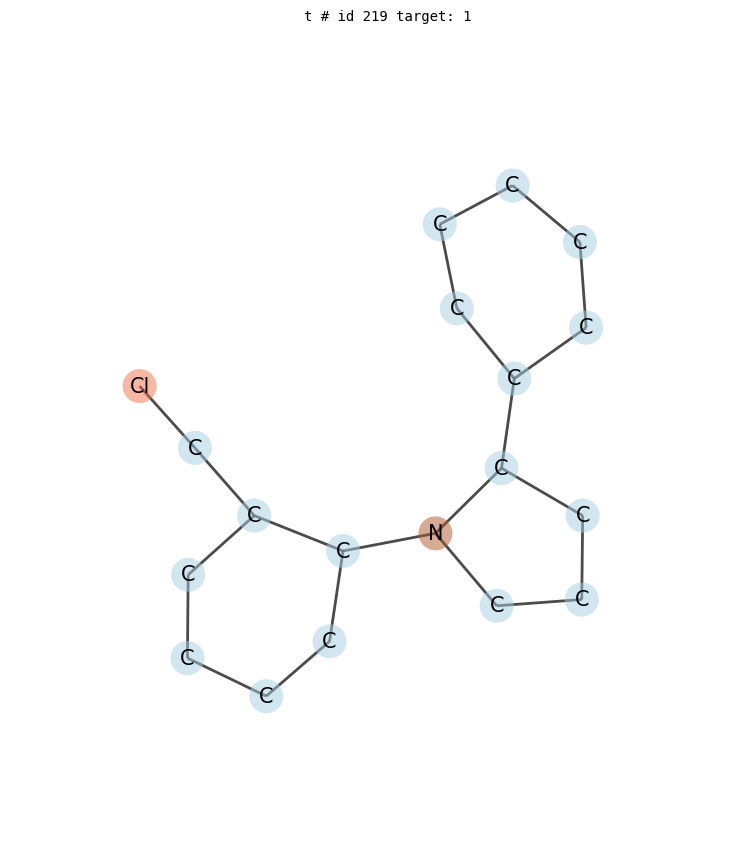

In [7]:
from  graphlearn.utils import draw
    
scores=[]
ids=range(id_start,id_end)
for i,path_graphs in enumerate(graphs):
    # for each sampling path:
    print 'Graph id: %d'%(ids[i])
    
    #collect scores so that we can display the score graph later 
    scores.append( sampler.monitors[i].sampling_info['score_history'] )
    
    # show graphs
    draw.graphlearn(path_graphs,
                        n_graphs_per_line=5, size=10, 
                       colormap='Paired', invert_colormap=False, vertex_color='_label_',
                        vertex_alpha=0.5, edge_alpha=0.7)


## plot score graph

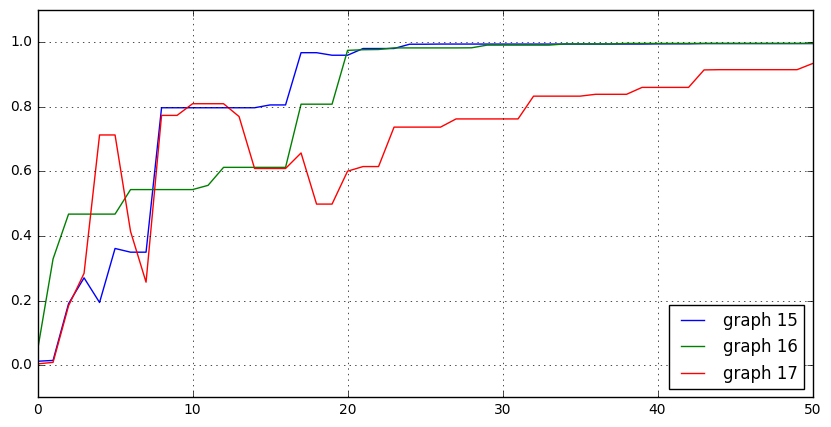

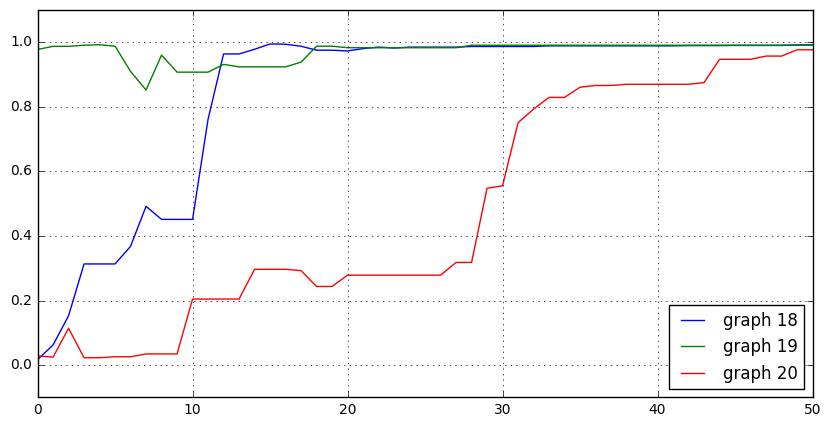

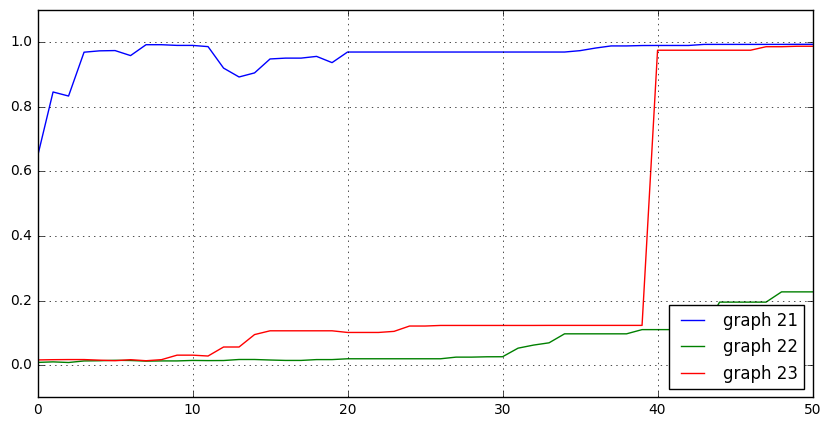

In [8]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt

step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

---